<a href="https://colab.research.google.com/github/pudyasta/energy_forecasting/blob/main/Energy_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install ucimlrepo

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from ucimlrepo import fetch_ucirepo

color_pal = sns.color_palette()

In [79]:
dats = fetch_ucirepo(id=235)
df = dats.data.features
df = df.drop(['Global_reactive_power', 'Voltage', 'Global_intensity'], axis=1)

/usr/local/lib/python3.11/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [80]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.DateTime = pd.to_datetime(df.DateTime)
df.set_index('DateTime', inplace=True)

df.drop(columns=['Date', 'Time'], inplace=True)

<ipython-input-80-8805515ce15f>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


#1st version


In [ ]:
df.tail(1440)

,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date,,,,,,,,
2010-11-25,21:03:00,1.504,0.104,241.41,6.2,0.0,0.0,0.0
2010-11-25,21:04:00,1.422,0.0,241.56,5.8,0.0,0.0,0.0
2010-11-25,21:05:00,1.414,0.0,241.83,5.8,0.0,0.0,0.0
2010-11-25,21:06:00,1.426,0.0,242.99,5.8,0.0,0.0,0.0
2010-11-25,21:07:00,1.426,0.0,242.11,5.8,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2010-11-26,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2010-11-26,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0


In [ ]:
sub_metering_cols = ["Global_active_power","Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]
for col in sub_metering_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df.rename(columns={"Global_active_power": "gap",
                   "Sub_metering_1": "sm1",
                   "Sub_metering_2": "sm2",
                   "Sub_metering_3": "sm3"}, inplace=True)

# Convert global_active_power from kW to kWh per minute
df["energy_kwh"] = df["gap"] * (1/60)

# Convert sub-metering from Wh to kWh
df["sub_metered_kwh"] = (df["sm1"] + df["sm2"] + df["sm3"]) / 1000

In [ ]:
# Group by day
daily_energy = df.groupby("Date").agg(
    total_energy_kwh=("energy_kwh", "mean"),   # Take the average
    metered_energy_kwh=("sub_metered_kwh", "mean")
)

daily_energy *= 1440

# Compute non-metered energy
daily_energy["non_metered_kwh"] = daily_energy["total_energy_kwh"] - daily_energy["metered_energy_kwh"]

In [ ]:
daily_energy.head(18)

,total_energy_kwh,metered_energy_kwh,non_metered_kwh
Date,,,
2006-12-16,73.283394,19.898182,53.385212
2006-12-17,56.507667,19.561000,36.946667
2006-12-18,36.730433,17.702000,19.028433
2006-12-19,27.769900,14.638000,13.131900
2006-12-20,37.095800,16.711000,20.384800
2006-12-21,28.650192,14.829597,13.820595
2006-12-22,39.022300,14.632000,24.390300
2006-12-23,79.556433,17.820000,61.736433
2006-12-24,42.500200,13.676000,28.824200


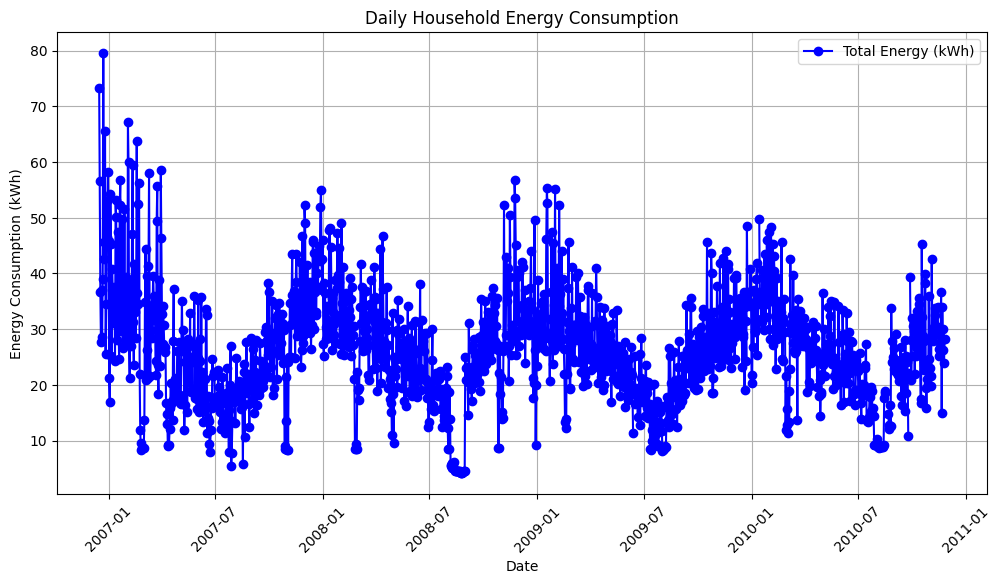

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(daily_energy.index, daily_energy["total_energy_kwh"], label="Total Energy (kWh)", color="blue", marker="o")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.title("Daily Household Energy Consumption")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

#2nd Version


In [63]:
df.head(10)

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,
2006-12-16 17:24:00,4.216,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.000,1.000,17.0
2006-12-16 17:29:00,3.520,0.000,2.000,17.0
2006-12-16 17:30:00,3.702,0.000,1.000,17.0
2006-12-16 17:31:00,3.700,0.000,1.000,17.0
2006-12-16 17:32:00,3.668,0.000,1.000,17.0


## Handling null value

In [64]:
df.isnull().sum()

,0
Global_active_power,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,25979


In [81]:
value_to_search = "?"
result = df[df['Global_active_power'] == value_to_search]
result.head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,
2006-12-21 11:23:00,?,?,?,NaN
2006-12-21 11:24:00,?,?,?,NaN
2006-12-30 10:08:00,?,?,?,NaN
2006-12-30 10:09:00,?,?,?,NaN
2007-01-14 18:36:00,?,?,?,NaN


In [82]:
df = df[df['Global_active_power'] != '?']

In [83]:
value_to_search = "?"
result = df[df['Global_active_power'] == value_to_search]
result.head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,


In [84]:
df.isnull().sum()

,0
Global_active_power,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


## Features Creation

In [86]:
def create_features(df):
    """
    Create time series features based on datetime index.
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)  # Ensure index is datetime

    df['Hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    return df

df = create_features(df)
df.head()


,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
DateTime,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.000,1.000,17.0,17,5,4,12,2006,350,16,50
2006-12-16 17:25:00,5.360,0.000,1.000,16.0,17,5,4,12,2006,350,16,50
2006-12-16 17:26:00,5.374,0.000,2.000,17.0,17,5,4,12,2006,350,16,50
2006-12-16 17:27:00,5.388,0.000,1.000,17.0,17,5,4,12,2006,350,16,50
2006-12-16 17:28:00,3.666,0.000,1.000,17.0,17,5,4,12,2006,350,16,50


##Handling a day that doesnt have 1440 columns
This approach aimed to have records of each minutes in a day

### Visualization

In [92]:
data_per_day = df[df.index.date == pd.to_datetime("2007-03-26").date()]


In [93]:
data_per_day

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
DateTime,,,,,,,,,,,,
2007-03-26 00:00:00,1.272,0.000,0.000,18.0,0,0,1,3,2007,85,26,13
2007-03-26 00:01:00,1.286,0.000,0.000,18.0,0,0,1,3,2007,85,26,13
2007-03-26 00:02:00,1.292,0.000,0.000,17.0,0,0,1,3,2007,85,26,13
2007-03-26 00:03:00,1.290,0.000,0.000,18.0,0,0,1,3,2007,85,26,13
2007-03-26 00:04:00,1.284,0.000,0.000,18.0,0,0,1,3,2007,85,26,13
...,...,...,...,...,...,...,...,...,...,...,...,...
2007-03-26 23:55:00,0.324,0.000,0.000,0.0,23,0,1,3,2007,85,26,13
2007-03-26 23:56:00,0.320,0.000,0.000,0.0,23,0,1,3,2007,85,26,13
2007-03-26 23:57:00,0.316,0.000,0.000,0.0,23,0,1,3,2007,85,26,13


In [94]:
rows_per_day = df.groupby(df.index.date).size()

# 1440 == total minutes per day
days_with_missing_rows = rows_per_day[rows_per_day != 1440]

days_with_missing_rows.sort_values(ascending=True)

,0
2007-04-28,21
2009-06-13,30
2010-08-22,152
2010-03-20,232
2010-09-25,236
...,...
2010-06-29,1439
2010-04-11,1439
2010-07-15,1439
2010-05-13,1439


In [109]:
df.index = pd.to_datetime(df.index)

def find_missing_minutes_for_day(df, date):
    # Create full minute-by-minute datetime range for that day
    full_range = pd.date_range(start=date, end=date + pd.Timedelta(days=1) - pd.Timedelta(minutes=1), freq='T')

    # Get existing timestamps for that day
    actual_times = df.loc[df.index.date == date.date()].index

    # Find missing timestamps
    missing = full_range.difference(actual_times)

    return missing

# Collect missing minutes for all problematic days
missing_minutes_list = []

for day in days_with_missing_rows.index:
    day_ts = pd.to_datetime(day)  # convert to Timestamp
    missing_minutes = find_missing_minutes_for_day(df, day_ts)
    missing_minutes_list.append({
        "day": str(day),  # you can keep it as Timestamp too if needed
        "missing_minutes": missing_minutes
    })
# Show example output
for entry in missing_minutes_list:
    print(f"\nMissing minutes on {entry['day']}:")
    print(entry['missing_minutes'])


<ipython-input-109-29712f388018>:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=date, end=date + pd.Timedelta(days=1) - pd.Timedelta(minutes=1), freq='T')



Missing minutes on 2006-12-16:
DatetimeIndex(['2006-12-16 00:00:00', '2006-12-16 00:01:00',
               '2006-12-16 00:02:00', '2006-12-16 00:03:00',
               '2006-12-16 00:04:00', '2006-12-16 00:05:00',
               '2006-12-16 00:06:00', '2006-12-16 00:07:00',
               '2006-12-16 00:08:00', '2006-12-16 00:09:00',
               ...
               '2006-12-16 17:14:00', '2006-12-16 17:15:00',
               '2006-12-16 17:16:00', '2006-12-16 17:17:00',
               '2006-12-16 17:18:00', '2006-12-16 17:19:00',
               '2006-12-16 17:20:00', '2006-12-16 17:21:00',
               '2006-12-16 17:22:00', '2006-12-16 17:23:00'],
              dtype='datetime64[ns]', length=1044, freq='min')

Missing minutes on 2006-12-21:
DatetimeIndex(['2006-12-21 11:23:00', '2006-12-21 11:24:00'], dtype='datetime64[ns]', freq='min')

Missing minutes on 2006-12-30:
DatetimeIndex(['2006-12-30 10:08:00', '2006-12-30 10:09:00'], dtype='datetime64[ns]', freq='min')

Missing minute

###+++

In [144]:
def fill_missing_minute(df, timestamp):
    timestamp = pd.to_datetime(timestamp)

    target_day = timestamp.dayofweek
    target_time = timestamp.time()
    # target_season = df.quarter  # The problem was likely here
    target_season = timestamp.quarter  # Correctly assign target_season using the timestamp

    # Filter to same minute, same weekday, same season
    similar_minutes = df[
        (df['dayofweek'] == target_day) &
        (df.index.time == target_time) &
        (df['quarter'] == target_season)
    ]

    # Calculate mean Global_active_power
    newMinutes = pd.DataFrame({
        'Global_active_power': pd.to_numeric(similar_minutes['Global_active_power'], errors='coerce').mean(),
        'Sub_metering_1': pd.to_numeric(similar_minutes['Sub_metering_1'], errors='coerce').mean(),
        'Sub_metering_2': pd.to_numeric(similar_minutes['Sub_metering_2'], errors='coerce').mean(),
        'Sub_metering_3': pd.to_numeric(similar_minutes['Sub_metering_3'], errors='coerce').mean(),
        "quarter": target_season,
        "dayofweek": target_day,
        "Hour": timestamp.hour,
        "month": timestamp.month,
        "year": timestamp.year,
        "dayofyear": timestamp.dayofyear,
        "dayofmonth": timestamp.day,
        "weekofyear": timestamp.isocalendar().week
    },index=[timestamp])

    return newMinutes

# res = fill_missing_minute(df,"2010-08-22 00:01:00" )
# res
# df = pd.concat([df,res])
# df.loc[df.index == pd.to_datetime("2010-08-22 00:01:00")]



,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2010-08-22 00:01:00,0.843569,0.078431,0.372549,2.960784,0,6,3.0,8,2010,234,22,33
2010-08-22 00:01:00,0.843569,0.078431,0.372549,2.960784,0,6,3.0,8,2010,234,22,33
2010-08-22 00:01:00,0.843569,0.078431,0.372549,2.960784,0,6,3.0,8,2010,234,22,33
2010-08-22 00:01:00,0.843569,0.078431,0.372549,2.960784,0,6,3.0,8,2010,234,22,33
2010-08-22 00:01:00,0.843569,0.078431,0.372549,2.960784,0,6,3.0,8,2010,234,22,33
2010-08-22 00:01:00,0.843569,0.078431,0.372549,2.960784,0,6,3.0,8,2010,234,22,33
2010-08-22 00:01:00,0.843569,0.078431,0.372549,2.960784,0,6,3.0,8,2010,234,22,33
2010-08-22 00:01:00,0.843569,0.078431,0.372549,2.960784,0,6,3.0,8,2010,234,22,33
2010-08-22 00:01:00,0.843569,0.078431,0.372549,2.960784,0,6,3.0,8,2010,234,22,33
2010-08-22 00:01:00,0.843569,0.078431,0.372549,2.960784,0,6,3.0,8,2010,234,22,33


In [ ]:
for entry in missing_minutes_list:
    for missing_minute in entry['missing_minutes']:
        new_minute = fill_missing_minute(df, missing_minute)
        df = pd.concat([df, new_minute])


In [ ]:
rows_per_day = df.groupby(df.index.date).size()

# 1440 == total minutes per day
days_with_missing_rows = rows_per_day[rows_per_day != 1440]

days_with_missing_rows.sort_values(ascending=True)

<ipython-input-12-ea90f5cac36c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_per_day['Global_active_power'] = pd.to_numeric(data_per_day['Global_active_power'], errors='coerce')


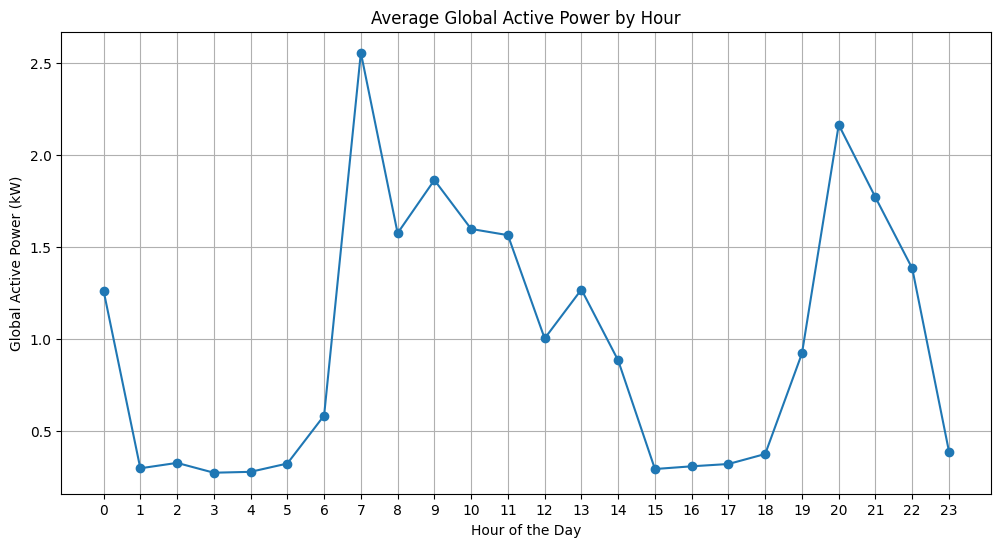

In [12]:
data_per_day['Global_active_power'] = pd.to_numeric(data_per_day['Global_active_power'], errors='coerce')

plt.figure(figsize=(12, 6))
plt.plot(data_per_day.groupby('Hour')['Global_active_power'].mean(), marker='o', linestyle='-')

# Formatting the plot
plt.xlabel('Hour of the Day')
plt.ylabel('Global Active Power (kW)')
plt.title('Average Global Active Power by Hour')
plt.xticks(range(0, 24))  # Ensure all hours are shown
plt.grid(True)
plt.show()


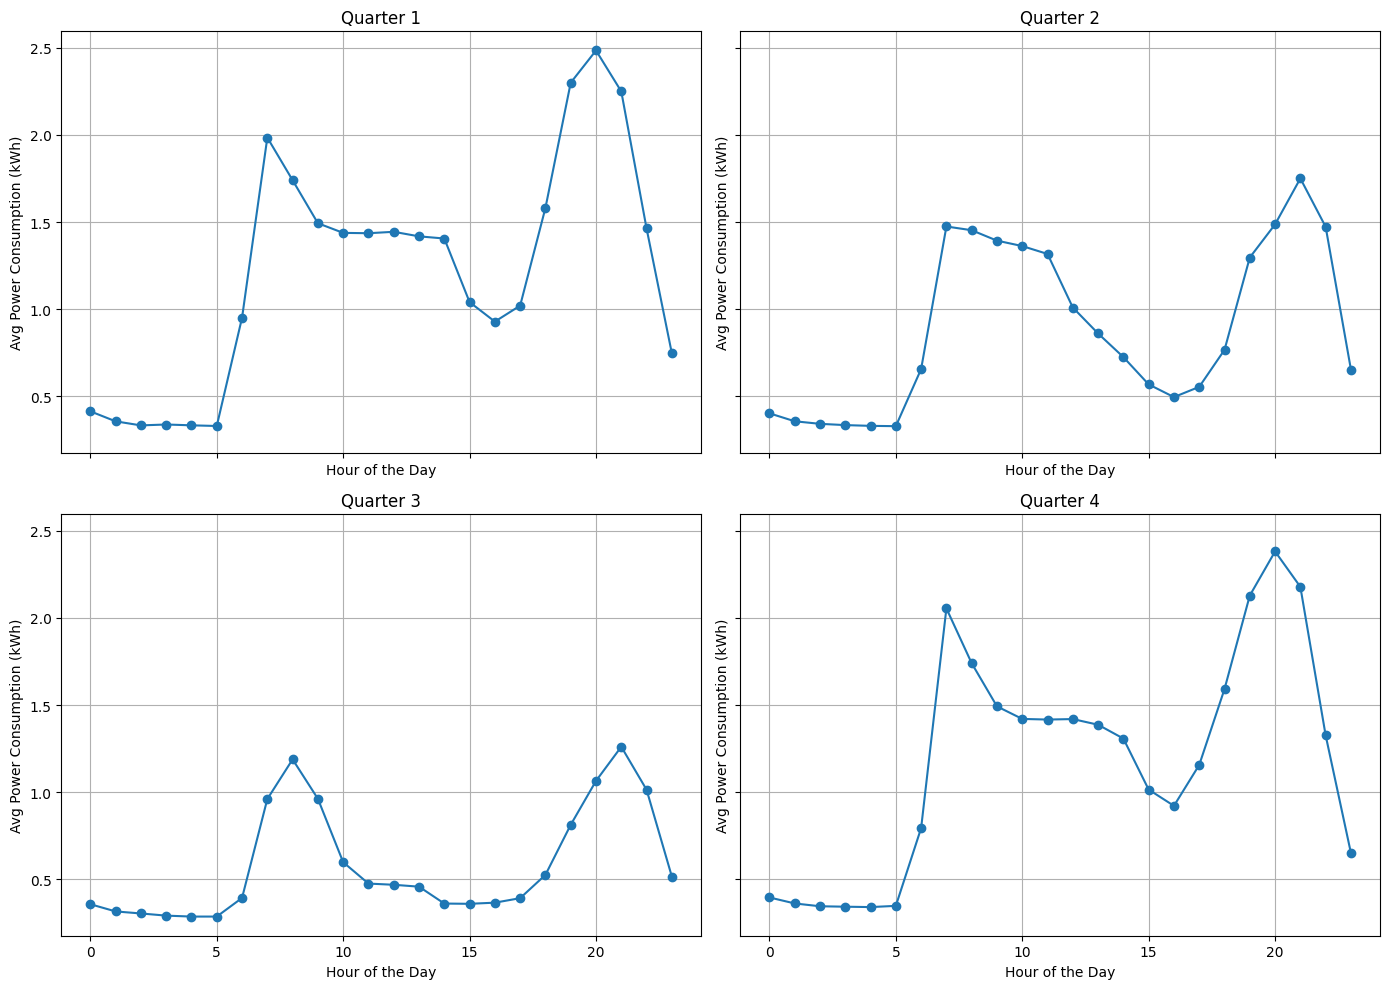

In [13]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

for q, ax in zip(range(1, 5), axes.flatten()):
    quarter_data = df[df['quarter'] == q]

    daily_hourly_sum = quarter_data.groupby(['Date', 'Hour'])['Global_active_power'].mean()
    avg_power = daily_hourly_sum.groupby('Hour').median()

    ax.plot(avg_power.index, avg_power.values, marker='o', linestyle='-')
    ax.set_title(f'Quarter {q}')
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Avg Power Consumption (kWh)')
    ax.grid(True)

plt.tight_layout()
plt.show()

### Encoding

In [15]:
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'])

df.set_index('DateTime', inplace=True)
all_minutes = pd.date_range(start=df.index.min(), end=df.index.max(), freq='min')
df_reindexed = df.reindex(all_minutes)
df_reindexed = df_reindexed.reset_index().rename(columns={'index': 'DateTime'})

df_reindexed['Date'] = df_reindexed['DateTime'].dt.date
df_reindexed['Time'] = df_reindexed['DateTime'].dt.time

df_reindexed.head()

,DateTime,Date,Time,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2006-12-16 17:24:00,2006-12-16,17:24:00,4.216,0.000,1.000,17.0,17,5,4,12,2006,350,16,50
1,2006-12-16 17:25:00,2006-12-16,17:25:00,5.360,0.000,1.000,16.0,17,5,4,12,2006,350,16,50
2,2006-12-16 17:26:00,2006-12-16,17:26:00,5.374,0.000,2.000,17.0,17,5,4,12,2006,350,16,50
3,2006-12-16 17:27:00,2006-12-16,17:27:00,5.388,0.000,1.000,17.0,17,5,4,12,2006,350,16,50
4,2006-12-16 17:28:00,2006-12-16,17:28:00,3.666,0.000,1.000,17.0,17,5,4,12,2006,350,16,50


In [16]:
df_reindexed.isna().sum()

,0
DateTime,0
Date,0
Time,0
Global_active_power,25979
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,25979
Hour,0
dayofweek,0
quarter,0


In [ ]:
df_reindexed['Global_active_power'] = pd.to_numeric(df_reindexed['Global_active_power'], errors='coerce')
df_reindexed['Sub_metering_1'] = pd.to_numeric(df_reindexed['Sub_metering_1'], errors='coerce')
df_reindexed['Sub_metering_2'] = pd.to_numeric(df_reindexed['Sub_metering_2'], errors='coerce')
df_reindexed['Sub_metering_3'] = pd.to_numeric(df_reindexed['Sub_metering_3'], errors='coerce')

# Group by minute, hour, and quarter and calculate the mean for specified columns
df_encoded = df_reindexed.groupby([df_reindexed['DateTime'].dt.minute,
                                  df_reindexed['DateTime'].dt.hour,
                                  df_reindexed['DateTime'].dt.quarter
                                 ])[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].transform('mean')

# Rename columns to indicate they are encoded
df_encoded = df_encoded.rename(columns={
    'Global_active_power': 'gap_encoded',
    'Sub_metering_1': 'sm1_encoded',
    'Sub_metering_2': 'sm2_encoded',
    'Sub_metering_3': 'sm3_encoded'
})

# Concatenate the encoded columns with the original DataFrame
df_reindexed = pd.concat([df_reindexed, df_encoded], axis=1)

# Now df_reindexed contains the original data and the encoded values for
# Global_active_power and sub-metering 1-3 based on minute, hour, and quarter.
